In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree


In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree

In [3]:
anatree.read_parquet('../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)
# merged = anatree.get_full_reco_tracks().collect()
# pl.collect_all(anatree.nu)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [5]:
nu = anatree.nu
geant = anatree.geant
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
pfp = anatree.pfp
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu[:]):
    df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

In [6]:
import particle 
pdg_list = merged.with_columns(
    pl.col('pdg_geant').abs()
).groupby('pdg_geant').agg(
    counts = pl.col('pdg_geant').count(),
    pdgs_name = pl.col('pdg_geant').first().apply(particle.Particle.from_pdgid),
    as_mothers = pl.col('Mother_geant').filter(pl.col('Mother_geant') == 0).count()
).sort('pdg_geant')


pl.Config.set_tbl_rows(100)
print(pdg_list)



shape: (24, 4)
┌────────────┬────────┬───────────┬────────────┐
│ pdg_geant  ┆ counts ┆ pdgs_name ┆ as_mothers │
│ ---        ┆ ---    ┆ ---       ┆ ---        │
│ i32        ┆ u32    ┆ object    ┆ u32        │
╞════════════╪════════╪═══════════╪════════════╡
│ 11         ┆ 6379   ┆ e-        ┆ 5346       │
│ 13         ┆ 4426   ┆ mu-       ┆ 4208       │
│ 22         ┆ 9299   ┆ gamma     ┆ 273        │
│ 211        ┆ 5753   ┆ pi+       ┆ 3245       │
│ 321        ┆ 148    ┆ K+        ┆ 85         │
│ 2212       ┆ 14654  ┆ p         ┆ 8186       │
│ 3112       ┆ 1      ┆ Sigma-    ┆ 1          │
│ 3222       ┆ 1      ┆ Sigma+    ┆ 1          │
│ 1000010020 ┆ 153    ┆ D2        ┆ 0          │
│ 1000010030 ┆ 15     ┆ T3        ┆ 0          │
│ 1000010040 ┆ 1      ┆ H4        ┆ 0          │
│ 1000020030 ┆ 1      ┆ He3       ┆ 0          │
│ 1000020040 ┆ 4      ┆ He4       ┆ 0          │
│ 1000150310 ┆ 1      ┆ P31       ┆ 0          │
│ 1000150320 ┆ 2      ┆ P32       ┆ 0          │
│ 100

In [4]:
anatree.nu = nu
anatree.geant = geant
anatree.reco_tracks = tracks
anatree.reco_showers = showers
merged = anatree.get_full_reco_tracks()

AttributeError: 'DataFrame' object has no attribute 'collect'

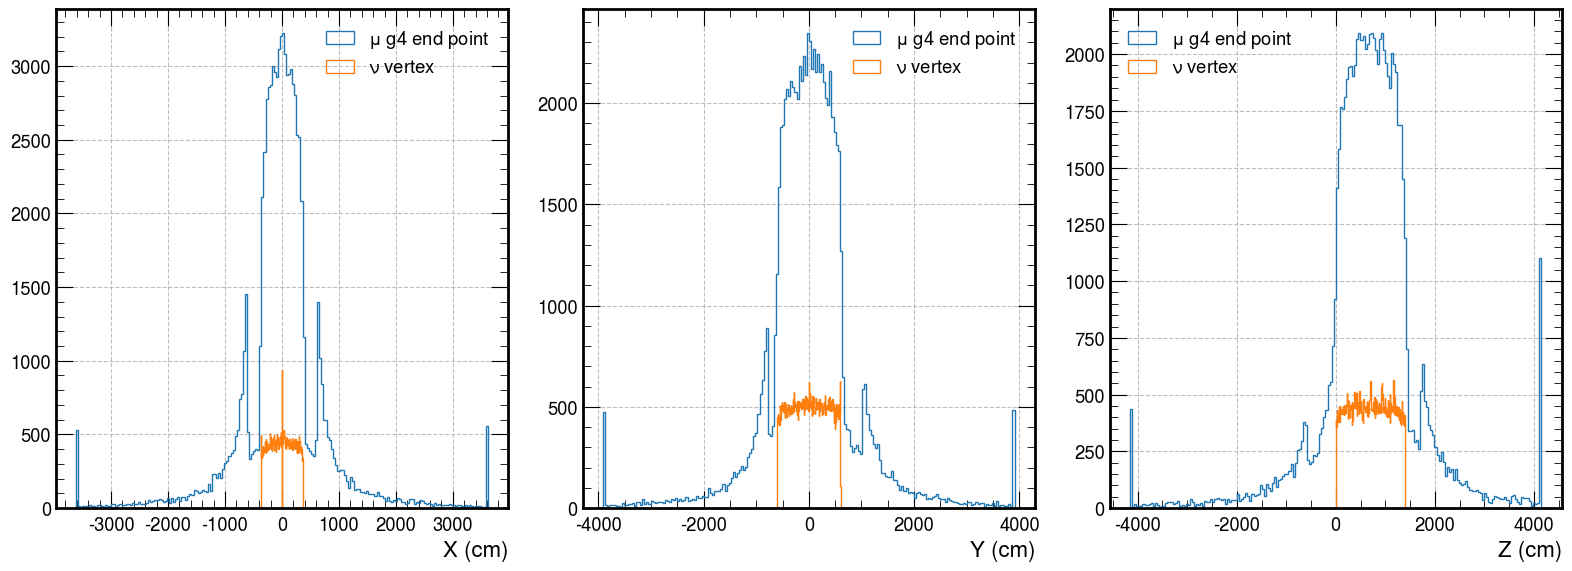

In [7]:
pl.Config.set_tbl_cols(20)
test = merged.filter(
    (pl.col('Mother_geant')==0) & (pl.col('pdg_geant').abs() == 13)
)

def make_plots(ax:plt.Axes, coord:str):
    ax.hist(test[f'EndPoint{coord}_geant'], bins = 200, histtype='step', label=rf'$\mu$ g4 end point')
    ax.hist(test[f'nuvtx{coord}'], bins = 200, histtype='step', label=rf'$\nu$ vertex')
    ax.set_xlabel(f'{coord.capitalize()} (cm)')
    ax.legend()

fig, axs = plt.subplots(1,3,figsize=(16,6))
make_plots(axs[0], 'x')
make_plots(axs[1], 'y')
make_plots(axs[2], 'z')

### Checking muons that scaped the TPC


In [8]:
# xlim = nu['nuvtxx'].abs().max()
# ylim = nu['nuvtxy'].abs().max()
# zmin = nu['nuvtxz'].min()
# zmax = nu['nuvtxz'].max()
xlim = 363.376 - 20
ylim = 607.829 - 20
zmin = -0.87625 + 20
zmax = 1393.46 - 20
print(f'{xlim} {ylim} {zmin} {zmax}')

# merged = geant.join(tracks, left_on=["subrun", "event", "TrackId_geant"], right_on=["subrun", "event", "trkg4id_pandoraTrack"], how="inner")

out_siders = test
out_siders = out_siders.groupby(["subrun", "event"]).agg(
    pl.all().sort_by('trklen_pandoraTrack').last()
)
out_siders.sort([ 'subrun','event' ])
out_siders = out_siders.filter(
    # ~(pl.col('EndPointx_geant').abs() < xlim) | ~(pl.col('EndPointy_geant').abs() < ylim) | ~( pl.col('EndPointz_geant') > zmin ) & ( pl.col('EndPointz_geant') < zmax )
    ~(pl.col('trkendx_pandoraTrack').abs() < xlim) | ~(pl.col('trkendy_pandoraTrack').abs() < ylim) | ~(( pl.col('trkendz_pandoraTrack') > zmin ) & ( pl.col('trkendz_pandoraTrack') < zmax ))
)

out_siders.sort('subrun').head(20)
out_siders.filter(
    True
    # pl.col('trkhasPFParticle_pandoraTrack') == 0
).sort('subrun')

343.376 587.829 19.12375 1373.46


subrun,event,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,…,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,mode_truth,nuvtxx,nuvtxy,nuvtxz
i32,i32,i16,f32,f32,f32,f32,f32,f32,i32,…,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
0,9,0,3477.580078,3362.11084,3392.647705,1443.206543,1442.735107,1443.221191,1,…,-603.170349,1222.501587,5.01884,0.29367,0.576258,-0.762688,1,4.910364,-576.209412,1185.788208
0,15,0,11.799114,11.86514,9.72438,5.88607,5.271137,5.02639,2,…,-598.956543,1087.422363,1.03482,-0.923,-0.017455,0.384419,0,-361.977875,-598.497009,1087.157104
1,2,1,31.035816,39.905575,36.84581,18.246683,17.802172,16.6593,2,…,-592.980164,946.59491,1.350398,-0.727417,-0.064326,-0.683182,0,-66.708664,-592.5578,946.769104
1,7,0,171.236145,193.598953,181.21492,73.829048,73.649864,72.546875,1,…,575.81427,780.27417,3.049114,-0.808027,-0.466471,0.359871,2,-297.759521,577.095886,779.826843
1,16,0,432.916962,410.257355,634.186218,181.985336,181.541397,181.807114,1,…,115.001869,475.716125,1.222746,-0.598878,-0.027724,-0.800368,0,-258.14389,114.031342,476.420166
2,5,0,166.021393,114.338722,168.51091,60.981819,52.142319,60.658497,1,…,-432.358948,826.692017,0.382575,-0.714908,-0.634498,-0.293813,0,336.940582,-486.195038,851.624817
3,3,0,2442.319336,2825.683838,2494.940918,1011.133972,1014.040283,1013.924622,1,…,-159.634109,423.942383,12.971225,0.65955,-0.027569,0.751163,2,-299.574005,-159.715469,424.075836
3,18,0,101.775078,102.726654,98.760643,27.343138,27.790489,27.48283,2,…,179.935165,1003.97406,0.334495,0.629388,0.609171,-0.482483,0,-349.451965,179.897049,1003.399475
3,10,0,257.570648,344.697876,327.809235,155.349197,160.840759,154.549255,1,…,532.293823,28.334661,1.252203,0.497213,0.436279,0.749967,1,129.912186,532.281982,28.144833


In [30]:
tmp = out_siders.select(
    pl.col('subrun'),
    pl.col('event'),
    pl.col('Eng_geant'),
    pl.col('EndPointx_geant'),
    pl.col('EndPointy_geant'),
    pl.col('EndPointz_geant'),
    # pl.col('trkg4id_pandoraTrack'),
    pl.col('trklen_pandoraTrack'),
    # pl.col('trkstartx_pandoraTrack'),
    # pl.col('trkstarty_pandoraTrack'),
    # pl.col('trkstartz_pandoraTrack'),
    pl.col('trkendx_pandoraTrack'),
    pl.col('trkendy_pandoraTrack'),
    pl.col('trkendz_pandoraTrack'),
    pl.col('trkPFParticleID_pandoraTrack')
).filter(
    True
    # (pl.col('event')==9) & (pl.col('subrun')==0)
).sort('subrun')
tmp.head(15)


# tracks.select(
#     pl.col('subrun'),
#     pl.col('event'),
#     pl.col('trkstartx_pandoraTrack'),
#     pl.col('trkstarty_pandoraTrack'),
#     pl.col('trkstartz_pandoraTrack'),
#     pl.col('trkendx_pandoraTrack'),
#     pl.col('trkendy_pandoraTrack'),
#     pl.col('trkendz_pandoraTrack')
# ).filter(
#     (pl.col('event')==9) & (pl.col('subrun')==0)
# )

subrun,event,Eng_geant,EndPointx_geant,EndPointy_geant,EndPointz_geant,trklen_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,trkPFParticleID_pandoraTrack
i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i16
0,9,4.463607,319.632996,328.466949,-221.026978,1443.608398,278.704956,199.624405,0.566093,0
0,15,0.466599,-237.972977,-619.322205,1169.43042,6.229081,-357.230743,-599.958679,1090.517456,0
10,14,1.556513,359.131927,-202.678391,544.666382,627.267212,358.39151,-202.379211,545.59082,0
11,15,0.296703,-352.695496,115.619522,665.867371,69.066956,-352.262054,116.442406,665.966309,0
11,6,9.670719,-238.762833,2055.427002,-1168.952148,559.243835,-88.492531,140.474487,0.79487,1
11,11,1.824093,-421.627899,1174.778687,1253.624512,234.858459,-43.888275,599.959656,1018.060059,0
11,12,0.40929,-246.269424,725.797791,1063.62854,26.026775,-333.985077,600.271057,882.068909,1
12,9,0.471207,614.429016,90.060417,835.843872,84.556,362.397949,-110.057915,977.718506,0
12,1,1.189455,-356.289948,430.833679,855.931396,492.789276,-355.986877,454.564758,838.870972,0


In [46]:
subsample = merged.select(
    pl.col(["subrun", "event"]),
    pl.col("pdg_geant"),
    pl.col("^trk.*$"),
).select(
    # pl.all()
    pl.exclude("^*cosmic.*$")
)
# merged['trkg4id_pandoraTrack']
# sample_with_PFP = subsample.filter(

#     pl.col("trkhasPFParticle_pandoraTrack")!=0
# )
# sample_without_PFP = subsample.filter(
#     pl.col("trkhasPFParticle_pandoraTrack")==0
# )

# subsample.groupby([ 'subrun' , 'event']).agg(
#     pl.all()
# ).sort(['subrun','event'])

# sample_without_PFP.groupby([ 'subrun' , 'event']).agg(
#     pl.all()
# ).sort(['subrun','event'])

# sample_without_PFP.groupby('subrun').agg(
#     pl.all()
# )

trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,…,trkpidchipi_pandoraTrack_z,trkpidchimu_pandoraTrack_x,trkpidchimu_pandoraTrack_y,trkpidchimu_pandoraTrack_z,trkpidpida_pandoraTrack_x,trkpidpida_pandoraTrack_y,trkpidpida_pandoraTrack_z,trkpidbestplane_pandoraTrack,trkhasPFParticle_pandoraTrack,trkPFParticleID_pandoraTrack
i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,…,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16
0,1476.505859,1362.933228,1683.381348,798.527405,797.377136,798.670837,1,1,1,…,2.353055,4.277405,30.71287,2.46693,8.585032,2.21278,8.214401,0,1,0
0,1.2417e9,2.1737e6,2.6077276e7,363.065247,355.107483,253.958633,2,2,2,…,34.401455,50.068401,8.917578,25.362474,0.87089,5.390366,4.357722,0,0,-1
2,136.023407,233.759064,220.873581,109.349487,123.521263,124.099213,7,7,7,…,18.108091,6.373022,8.151433,10.528322,6.415412,5.540125,5.591452,2,1,2
1,843.119385,742.362793,1084.849487,402.720062,404.477386,467.400696,1,1,1,…,11.312902,13.737896,40.190624,6.873935,4.988409,1.497825,6.154869,2,1,1
1,876.27179,1736.10083,4355.391113,278.079865,384.670319,449.971161,2181,2181,2181,…,-99999.0,23.059032,9.551797,-99999.0,1.631056,3.662461,-99999.0,1,0,-1
3,339.400024,142.811691,228.884262,188.72641,158.234299,178.806488,1107,1107,1107,…,34.323151,24.554359,21.477213,21.843901,1.493873,2.002241,1.983243,0,0,-1
0,1377.168457,1545.251221,1317.904053,589.975159,637.443665,565.187805,1,1,1,…,-99999.0,12.546865,11.287549,-99999.0,6.214195,5.403179,-99999.0,1,0,-1
0,58281.710938,137399.453125,5.0195696e8,553.821777,620.588684,588.565857,20313,20313,20313,…,-99999.0,37.178082,0.090078,-99999.0,0.673369,8.468921,-99999.0,1,0,-1
0,2062.045898,1948.026733,2165.294678,905.197266,905.892517,906.51886,1,1,1,…,10.471569,6.346371,29.586645,5.991809,6.253466,1.950269,6.322785,0,1,0


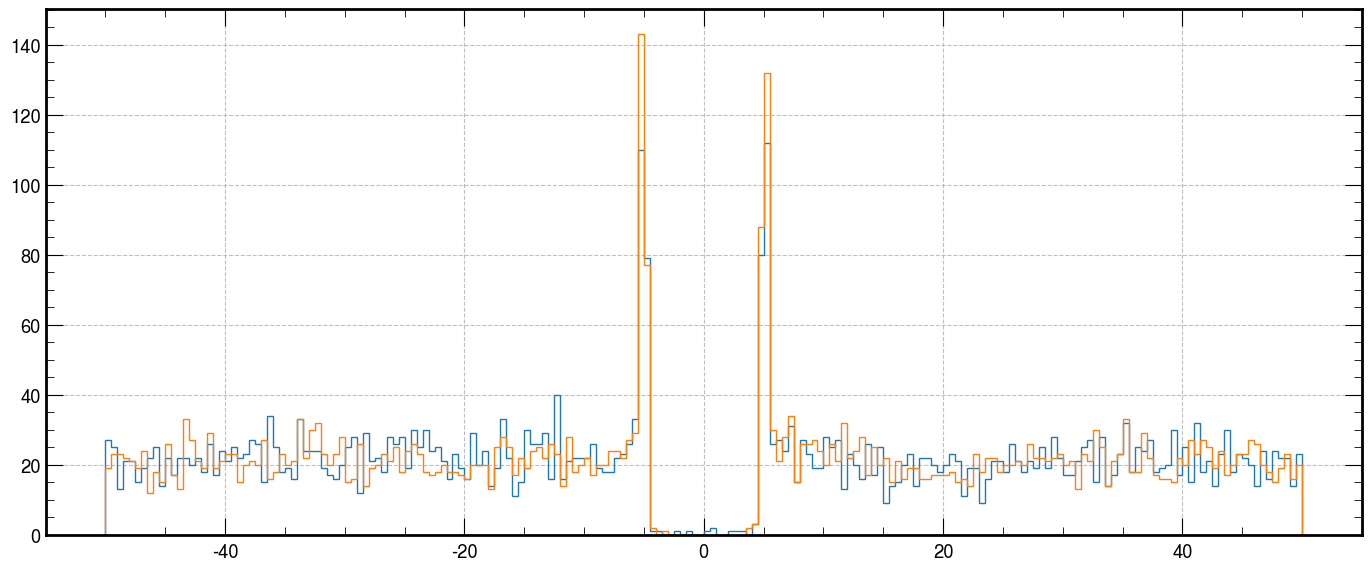

In [47]:
plt.hist(tracks['trkendx_pandoraTrack'], bins=200, range=(-50,50), histtype='step');
plt.hist(tracks['trkstartx_pandoraTrack'], bins=200, range=(-50,50), histtype='step');
# pl.Config.set_tbl_cols(100)
tracks.filter(
    (pl.col('trkendx_pandoraTrack')*pl.col('trkstartx_pandoraTrack') < 0) 
).select(
    pl.col('^trk.*$')
).select(
    pl.exclude("^*cosmic.*$")
)



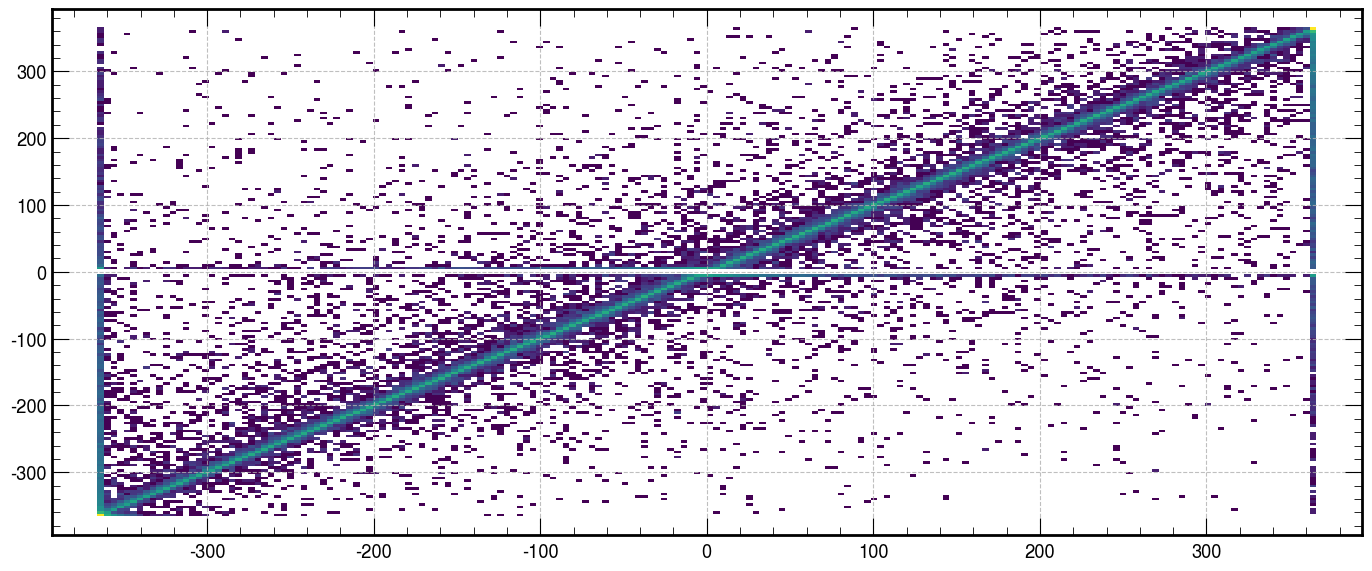

In [9]:

tmp = merged.filter(
    (pl.col('pdg_geant').abs() == 13) & (pl.col('Mother_geant')== 0),
).filter(
    ( pl.col('trkhasPFParticle_pandoraTrack') == 1 )

)
plotlim = xlim+50
plt.hist2d(tmp['EndPointx_drifted_geant'], tmp['trkendx_pandoraTrack'], bins=(200,200), range=((-plotlim,plotlim),(-plotlim,plotlim)), norm=LogNorm());


In [86]:
anatree.tree["EndE_drifted_geant"]
cols = [key for key in anatree.tree.keys() if 'trk' in key] 
# cols.remove("no_primaries_geant")
# cols.remove("geant_list_size_geant")
# cols.remove("geant_list_size_in_tpcAV_geant")
cols
test = [col.name for col in tracks.mean().select(pl.all().max() < -99) if col.item()]

exclusion_list = ['cosmic', 'T0', 'momms', 'pidmva', 'evtxid']  #all this are empty
cols = [x for x in cols if any(exclusion_item not in x for exclusion_item in exclusion_list)]
cols
# cols = set(cols)
# test = set(test)
cols

# test
# tracks.mean().select(
#     pl.all().max() > 0
# )

# [col.item() for col in tracks.select(pl.all().max()<0)]

['trkId_pandoraTrack',
 'trkncosmictags_tagger_pandoraTrack',
 'trkcosmicscore_tagger_pandoraTrack',
 'trkcosmictype_tagger_pandoraTrack',
 'trkncosmictags_containmenttagger_pandoraTrack',
 'trkcosmicscore_containmenttagger_pandoraTrack',
 'trkcosmictype_containmenttagger_pandoraTrack',
 'trkncosmictags_flashmatch_pandoraTrack',
 'trkcosmicscore_flashmatch_pandoraTrack',
 'trkcosmictype_flashmatch_pandoraTrack',
 'trkke_pandoraTrack',
 'trkrange_pandoraTrack',
 'trkidtruth_pandoraTrack',
 'trkorigin_pandoraTrack',
 'trkpdgtruth_pandoraTrack',
 'trkefftruth_pandoraTrack',
 'trkpurtruth_pandoraTrack',
 'trkpitchc_pandoraTrack',
 'ntrkhits_pandoraTrack',
 'trkdedx_pandoraTrack',
 'trkdqdx_pandoraTrack',
 'trkresrg_pandoraTrack',
 'trktpc_pandoraTrack',
 'trkxyz_pandoraTrack',
 'trkstartx_pandoraTrack',
 'trkstarty_pandoraTrack',
 'trkstartz_pandoraTrack',
 'trkstartd_pandoraTrack',
 'trkendx_pandoraTrack',
 'trkendy_pandoraTrack',
 'trkendz_pandoraTrack',
 'trkendd_pandoraTrack',
 'trkfla

In [12]:
def merge_same_df(dataframes:list):
    merged:pl.DataFrame
    merged = 0
    for i, df in enumerate(dataframes):
        df = df.collect()
        if i == 0:
            merged = df
        else:
            merged = pl.concat([merged,df])
    return merged
# shw = merge_same_df(shw)
# pfp = merge_same_df(pfp)
tracks = merge_same_df(tracks)

In [69]:
shf:pl.DataFrame
tkf:pl.DataFrame
shf = shw.groupby(selection_events()).agg(
    ntrks = pl.col('pfp_parentID').count()
)
tkf = tracks.groupby(selection_events()).agg(
    nshws = pl.col('pfp_parentID').count()
)

diff_ev = tkf.join(shf, on=selection_events(), how='outer')

diff_ev = diff_ev.fill_null(0).filter(
    ( pl.col('ntrks') != pl.col('nshws') ) 
).with_columns(
    test = pl.col('nshws').cast(pl.Int16) - pl.col('ntrks') 
)

filter_diff = diff_ev.select(selection_events())

shw_diff = shw.join(filter_diff, on=selection_events(), how='inner')
shw_diff
    

subrun,event,shwr_bestplane_pandoraShower,shwr_length_pandoraShower,shwr_startdcosx_pandoraShower,shwr_startdcosy_pandoraShower,shwr_startdcosz_pandoraShower,shwr_startx_pandoraShower,shwr_starty_pandoraShower,shwr_startz_pandoraShower,shwr_totEng_pandoraShower_x,shwr_totEng_pandoraShower_y,shwr_totEng_pandoraShower_z,shwr_dedx_pandoraShower_x,shwr_dedx_pandoraShower_y,shwr_dedx_pandoraShower_z,shwr_mipEng_pandoraShower_x,shwr_mipEng_pandoraShower_y,shwr_mipEng_pandoraShower_z,shwr_hasPFParticle_pandoraShower,shwr_PFParticleID_pandoraShower,shwr_pidmvamu_pandoraShower,shwr_pidmvae_pandoraShower,shwr_pidmvapich_pandoraShower,shwr_pidmvaphoton_pandoraShower,shwr_pidmvapr_pandoraShower,showerID_pandoraShower,pfp_parentID,has_valid_pfp
i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,f32,f32,f32,f32,f32,i16,i16,i16
0,4,1,96.466362,0.232655,0.909402,0.344761,37.694302,-406.247253,137.840637,464.195648,443.998779,451.559448,5.887189,9.460866,10.982842,-99999.0,-99999.0,-99999.0,1,0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,0,-1,0
0,4,1,16.136236,-0.509681,0.848531,-0.1422,122.727028,-275.15802,204.328583,107.303009,126.432251,106.487022,2.626674,3.108196,2.307724,-99999.0,-99999.0,-99999.0,1,1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,-1,0
0,4,0,5.87562,0.249815,0.784212,-0.567983,114.148003,-259.015442,201.038361,64.419044,-999.0,61.740231,9.92446,-999.0,9.538828,-99999.0,-99999.0,-99999.0,1,2,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2,-1,0
0,4,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,8.52058,24.656363,-999.0,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,3,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3,-1,1
0,5,0,24.156116,-0.226436,-0.57362,0.787202,92.810913,-494.948029,347.923615,94.819046,91.221069,91.665482,2.29058,2.629945,2.168712,-99999.0,-99999.0,-99999.0,1,0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,0,-1,0
0,5,0,9.15351,-0.842969,-0.392632,0.367755,48.093544,-491.475372,350.72171,46.294029,45.734295,51.824993,4.087903,2.750652,1.782876,-99999.0,-99999.0,-99999.0,1,1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,-1,1
0,5,1,9.786713,0.196534,0.752078,0.629089,93.6007,-490.392273,349.062988,64.850342,61.339409,38.52132,2.676831,7.194021,2.474085,-99999.0,-99999.0,-99999.0,1,2,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2,-1,0
0,5,0,5.850799,-0.972875,0.079743,-0.217152,91.186913,-494.322784,347.532867,51.982449,61.798157,54.32618,3.52661,4.127992,15.524368,-99999.0,-99999.0,-99999.0,1,3,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3,-1,0
0,5,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.743419,23.67831,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,4,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,4,-1,1


In [104]:
shw_valid = shw.filter(
    (pl.col('shwr_startx_pandoraShower') != -999) &
    (pl.col('shwr_starty_pandoraShower') != -999) &
    (pl.col('shwr_startz_pandoraShower') != -999)
    # (pl.col('shwr_totEng_pandoraShower_x') != -999) | (pl.col('shwr_totEng_pandoraShower_y') != -999) | (pl.col('shwr_totEng_pandoraShower_z') != -999)
# ).filter(
#     True
    # (pl.col('shwr_dedx_pandoraShower_x') != -999) & (pl.col('shwr_dedx_pandoraShower_y') != -999) & (pl.col('shwr_dedx_pandoraShower_z') != -999)
).filter(
    pl.col('shwr_length_pandoraShower') != -999
)
shf:pl.DataFrame
tkf:pl.DataFrame
shf = shw_valid.groupby(selection_events()).agg(
    ntrks = pl.col('pfp_parentID').count()
)
tkf = tracks.groupby(selection_events()).agg(
    nshws = pl.col('pfp_parentID').count()
)

diff_ev = tkf.join(shf, on=selection_events(), how='outer')

diff_ev = diff_ev.fill_null(0).filter(
    ( pl.col('ntrks') != pl.col('nshws') ) 
).with_columns(
    test = pl.col('nshws').cast(pl.Int16) - pl.col('ntrks') 
)

filter_diff = diff_ev.select(selection_events())

pfp_diff = pfp.join(filter_diff, on=selection_events(), how='inner')
pfp_diff.groupby(selection_events()).agg().sort(selection_events())


subrun,event
i32,i32
0,19
336,13
348,4
421,3
674,12
712,13
728,16
736,12
828,14


In [150]:
trk_id = tracks.select(selection_events(['trkPFParticleID_pandoraTrack']))
shw_id = shw_valid.select(selection_events(['shwr_PFParticleID_pandoraShower']))
diff_id = shw_id.join(trk_id, left_on=selection_events(['shwr_PFParticleID_pandoraShower']), right_on=selection_events(['trkPFParticleID_pandoraTrack']), how='anti')
diff_id.groupby(selection_events()).agg().sort(selection_events())

shw_diff = shw.join(diff_id, on=selection_events(['shwr_PFParticleID_pandoraShower']), how='inner')
shw_diff.groupby(selection_events()).agg().sort(selection_events())
print(f'Total extra showers left: {len(shw_diff)}')
print(f'Total actually showers left: {len(shw_diff.filter(pl.col("has_valid_pfp")==1))}')

Total extra showers left: 129
Total actually showers left: 17


In [149]:
trk_id = tracks.select(selection_events(['trkPFParticleID_pandoraTrack']))
shw_id = shw.select(selection_events(['shwr_PFParticleID_pandoraShower']))
diff_id = shw_id.join(trk_id, left_on=selection_events(['shwr_PFParticleID_pandoraShower']), right_on=selection_events(['trkPFParticleID_pandoraTrack']), how='anti')
diff_id.groupby(selection_events()).agg().sort(selection_events())

pfp_diff = pfp.join(diff_id, left_on=selection_events(['pfp_selfID']), right_on=selection_events(['shwr_PFParticleID_pandoraShower']), how='inner')
pfp_diff.groupby(selection_events()).agg().sort(selection_events())
print(f'Total extra showers: {len(pfp_diff)}')
print(f'Total extra actually showers: {len(pfp_diff.filter(pl.col("pfp_isShower")==1))}')

Total extra showers: 83621
Total extra actually showers: 6304


In [247]:
cc_numu = merged.filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
    )
print(f'Total events numu CC: {len(cc_numu.groupby(selection_events()).agg())}')
cc_numu_reco_mu = cc_numu.groupby(selection_events()).agg(
    has_mu_track = (pl.col('pdg_geant').abs() == 13).any()
)
cc_numu_reco_mu = cc_numu.join(cc_numu_reco_mu, on=selection_events(),how='inner')


print(f'Total CC numu with reco mu: {len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==True).groupby(selection_events()).agg())}')
print(f'Total CC numu without reco mu: {len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==False).groupby(selection_events()).agg())}')
cc_numu_longest_track = cc_numu_reco_mu.sort(
    pl.col('trklen_pandoraTrack'), descending=True
    ).groupby(selection_events()).agg(
        longest = pl.col('trklen_pandoraTrack').first(),
        is_track = pl.col('has_valid_pfp').first(),
        pdg = pl.col('pdg_geant').first(),
        nu_en = pl.col('enu_truth').first(),
        has_mu_track = pl.col('has_mu_track').first()
        ).sort(
            selection_events()
        ).filter(
            (pl.col('pdg').abs()!=13)
        )
print(f'Total longest track NOT muon (with reco muon): {len(cc_numu_longest_track.filter(pl.col("has_mu_track")==True))}')
print(f'Total longest track NOT muon (without reco muon): {len(cc_numu_longest_track.filter(pl.col("has_mu_track")==False))}')

Total events numu CC: 74060
Total CC numu with reco mu: 69001
Total CC numu without reco mu: 5059
Total longest track NOT muon (with reco muon): 10459
Total longest track NOT muon (without reco muon): 5059


In [243]:
cc_numu = merged.filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        pl.col('has_valid_pfp')==True
    )
print(f'Total events numu CC: {len(cc_numu.groupby(selection_events()).agg())}')
cc_numu_reco_mu = cc_numu.groupby(selection_events()).agg(
    has_mu_track = (pl.col('pdg_geant').abs() == 13).any()
)
cc_numu_reco_mu = cc_numu.join(cc_numu_reco_mu, on=selection_events(),how='inner')


print(f'Total CC numu with reco mu: {len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==True).groupby(selection_events()).agg())}')
print(f'Total CC numu without reco mu: {len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==False).groupby(selection_events()).agg())}')
cc_numu_longest_track = cc_numu_reco_mu.sort(
    pl.col('trklen_pandoraTrack'), descending=True
    ).groupby(selection_events()).agg(
        longest = pl.col('trklen_pandoraTrack').first(),
        is_track = pl.col('has_valid_pfp').first(),
        pdg = pl.col('pdg_geant').first(),
        nu_en = pl.col('enu_truth').first(),
        has_mu_track = pl.col('has_mu_track').first()
        ).sort(
            selection_events()
        ).filter(
            (pl.col('pdg').abs()!=13)
        )
print(f'Total longest track NOT muon (with reco muon): {len(cc_numu_longest_track.filter(pl.col("has_mu_track")==True))}')
print(f'Total longest track NOT muon (without reco muon): {len(cc_numu_longest_track.filter(pl.col("has_mu_track")==False))}')


Total events numu CC: 73107
Total CC numu with reco mu: 66860
Total CC numu without reco mu: 6247
Total longest track NOT muon (with reco muon): 5674
Total longest track NOT muon (without reco muon): 6247


subrun,event,longest,is_track,pdg,nu_en,has_mu_track
i32,i32,f32,i16,i32,f32,bool
1,2,30.441505,1,2212,1.350398,true
1,15,6.919324,1,11,0.175935,false
3,16,4.797275,1,2212,0.284051,true
4,15,58.921635,1,211,0.57727,true
5,12,1.741323,1,2212,0.971689,false
6,13,22.599405,1,2212,0.574551,true
9,2,1.599072,1,2212,0.202964,false
9,3,28.855745,1,1000010020,5.162422,false
10,5,11.34494,1,2212,0.290682,true
